In [1]:
import pandas as pd
from segmentation_pipelines import extract_masks_adapted, save_as_memmap
from caiman import load_memmap
import scanreader
import numpy as np

import pickle
from scipy.signal.windows import tukey
from scipy import interpolate as interp
from scipy import ndimage
import pyfftw
from imreg_dft import utils
from caiman import load_memmap
from scipy.ndimage import percentile_filter
from caiman.source_extraction.cnmf import deconvolution
import scipy
from scipy import fftpack

from segmentation_pipelines import (
        extract_masks_adapted,
        extract_masks_new,
        save_as_memmap,
    )

/tmp/ipykernel_5413/461499426.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-04 06:44:43.850553: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-04 06:44:43.890651: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 06:44:43.890687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin c

In [2]:
# The following import does not work because of a dependency error associated with
# an update in the collections package.
# Workaround to still be able to pull files from the database: save the scans to the VM
# under another docker image and load them in here
# In the future, we will need to update the pipeline repository to remove this dependency error

from pipeline.experiment import Scan

AttributeError: module 'collections' has no attribute 'MutableMapping'

Load in the memory-mapped file that was saved under another docker image that was able to access the database

In [5]:
filename = 'data/caiman/caiman_d1_240_d2_240_d3_1_order_C_frames_61717_.mmap'
mmap_scan, (image_height, image_width), num_frames = load_memmap(filename)

In [4]:
mmap_scan

memmap([[ 127.,   77.,   25., ...,  152.,   25.,   -5.],
        [ 501.,  511.,  646., ...,  186.,  218.,  657.],
        [ 269.,  107.,  222., ...,   84.,  152.,  295.],
        ...,
        [ 201.,  515.,  299., ...,  173.,   89.,  121.],
        [ 985., 1069., 1565., ...,  600.,  301.,  331.],
        [ 246.,  228.,    6., ...,   77.,  198.,  324.]], dtype=float32)

Convert the memory-mapped scan to a numpy array and reshape/reorder into the format expected by the segmentation method

In [6]:
scan = np.array(mmap_scan)

In [7]:
scan = scan.reshape(image_height, image_width, num_frames, order='F')
# if scan.min() < 0:
    # scan -= scan.min()
    # resave memory-mapped file after correcting for removal of negative values

Define the parameters for the segmentation method and perform segmentation

In [8]:
params = {'num_background_components': 1,
 'merge_threshold': 0.7,
 'fps': 8.3091,
 'init_on_patches': True,
 'proportion_patch_overlap': 0.2,
 'num_components_per_patch': 6,
 'init_method': 'greedy_roi',
 'patch_size': [20.0, 20.0],
 'soma_diameter': [3.2, 3.2],
 'num_processes': 8,
 'num_pixels_per_process': 10000}

In [11]:
masks, traces, background_masks, background_traces, raw_traces = extract_masks_adapted(scan, mmap_scan, **params)

[Thu Feb 15 21:23:00 2024] Starting 8 processes...
[Thu Feb 15 21:23:01 2024] Initializing components...
[Thu Feb 15 21:32:50 2024] 972 components found...
[Thu Feb 15 21:32:50 2024] Removing bad components...


[Thu Feb 15 21:33:29 2024] 967 components remaining...
[Thu Feb 15 21:33:29 2024] Calculating noise per pixel...
[Thu Feb 15 21:33:34 2024] Updating masks...
[Thu Feb 15 21:35:47 2024] Updating traces...
[Thu Feb 15 21:36:33 2024] Merging overlapping (and temporally correlated) masks...
[Thu Feb 15 21:36:48 2024] Refining masks...
[Thu Feb 15 21:38:13 2024] Refining traces...
[Thu Feb 15 21:39:01 2024] Removing bad components...
[Thu Feb 15 21:39:41 2024] 751 components remaining...
[Thu Feb 15 21:39:41 2024] Done.


save masks to a file for future analysis

In [12]:
np.save('masks_new3.npy', masks)

do some basic visualizations of data

In [8]:
import matplotlib.pyplot as plt

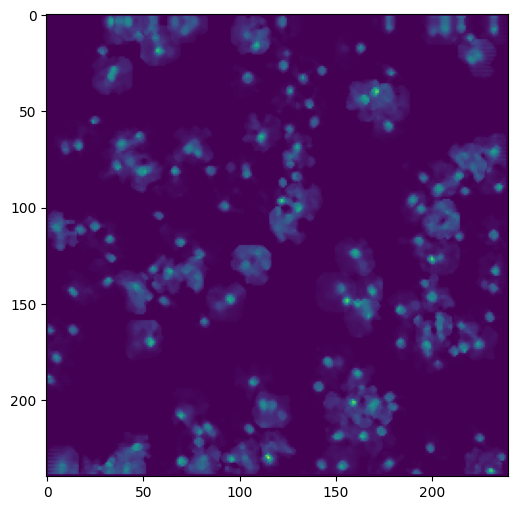

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(masks.sum(axis=-1))

<Axes: >

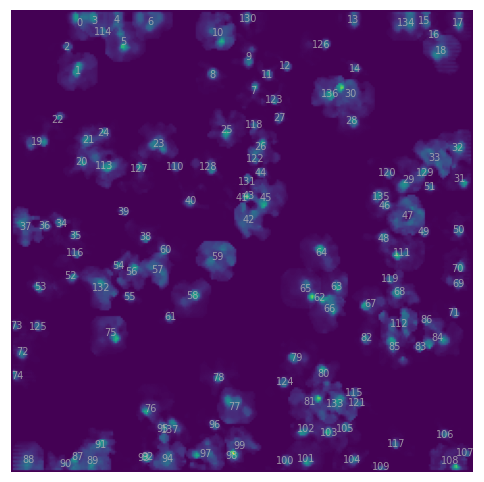

In [13]:
def label_masks(masks, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(masks.sum(axis=-1))

    for i in range(masks.shape[-1]):
        mask = masks[:,:,i]
        x_avg = np.average(np.arange(mask.shape[1]), weights=mask.sum(axis=0))
        y_avg = np.average(np.arange(mask.shape[0]), weights=mask.sum(axis=1))
        ax.text(x_avg, y_avg, i, ha='center', va='center', color='0.7', size=7, alpha=0.8)

    ax.set_axis_off()
    return ax

label_masks(masks)

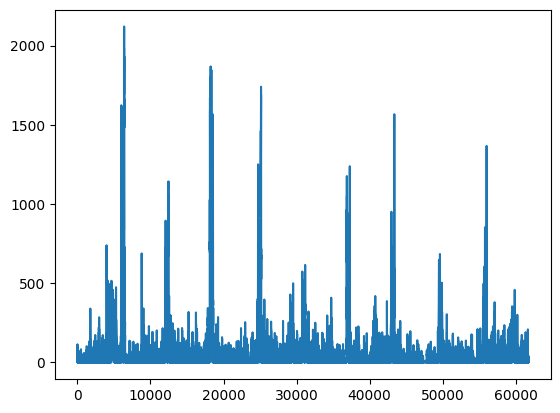

In [15]:
plt.plot(traces[0])

Define all functions needed to perform full pipeline on a scan (raster correction -> motion correction -> segmentation -> deconvolution)

In [2]:
def select_middle_frames(scan, skip_rows=0, skip_cols=0):
    # Load some frames from the middle of the scan
    num_frames = scan.shape[-1]
    middle_frame = int(np.floor(num_frames / 2))
    frames = slice(max(middle_frame - 1000, 0), middle_frame + 1000)
    last_row = -scan.shape[0] if skip_rows == 0 else skip_rows
    last_col = -scan.shape[1] if skip_cols == 0 else skip_cols
    mini_scan = scan[skip_rows:-last_row, skip_cols:-last_col, frames]

    return mini_scan


def raster_template_prep(scan):
    # Load middle 2000 frames from the scan
    mini_scan = select_middle_frames(scan)

    # get the height and width of the scan
    height, width = mini_scan.shape[:2]

    return mini_scan, height, width


def compute_raster_template(scan):
    mini_scan, height, width = raster_template_prep(scan)

    # Create template (average frame tapered to avoid edge artifacts)
    taper = np.sqrt(
        np.outer(
            tukey(height, 0.4),
            tukey(width, 0.4),
        )
    )
    anscombed = 2 * np.sqrt(mini_scan - mini_scan.min() + 3 / 8)  # anscombe transform
    template = np.mean(anscombed, axis=-1) * taper

    return template


def raster_phase_prep(image, temporal_fill_fraction):
    # Make sure image has even number of rows (so number of even and odd rows is the same)
    image = image[:-1] if image.shape[0] % 2 == 1 else image

    # Get some params
    image_height, image_width = image.shape
    skip_rows = round(image_height * 0.05)  # rows near the top or bottom have artifacts
    skip_cols = round(image_width * 0.10)  # so do columns

    # Create images with even and odd rows
    even_rows = image[::2][skip_rows:-skip_rows]
    odd_rows = image[1::2][skip_rows:-skip_rows]

    # Scan angle at which each pixel was recorded.
    max_angle = (np.pi / 2) * temporal_fill_fraction
    scan_angles = np.linspace(-max_angle, max_angle, image_width + 2)[1:-1]
    # sin_index = np.sin(scan_angles)

    even_interp, odd_interp = create_interp_functions(scan_angles, even_rows, odd_rows)

    return image, skip_rows, skip_cols, scan_angles, even_interp, odd_interp


def create_interp_functions(scan_angles, even_rows, odd_rows):
    even_interp = interp.interp1d(scan_angles, even_rows, fill_value="extrapolate")
    odd_interp = interp.interp1d(scan_angles, odd_rows, fill_value="extrapolate")
    return even_interp, odd_interp


def compute_raster_phase(image: np.array, temporal_fill_fraction: float) -> float:
    """Compute raster correction for bidirectional resonant scanners.

    It shifts the even and odd rows of the image in the x axis to find the scan angle
    that aligns them better. Positive raster phase will shift even rows to the right and
    odd rows to the left (assuming first row is row 0).

    :param np.array image: The image to be corrected.
    :param float temporal_fill_fraction: Fraction of time during which the scan is
        recording a line against the total time per line.

    :return: An angle (in radians). Estimate of the mismatch angle between the expected
         initial angle and the one recorded.
    :rtype: float
    """
    # Make sure image has even number of rows (so number of even and odd rows is the same)
    (
        image,
        skip_rows,
        skip_cols,
        scan_angles,
        even_interp,
        odd_interp,
    ) = raster_phase_prep(image, temporal_fill_fraction)

    # Greedy search for the best raster phase: starts at coarse estimates and refines them
    angle_shift = 0
    for scale in [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
        angle_shifts = angle_shift + scale * np.linspace(-9, 9, 19)
        match_values = []
        for new_angle_shift in angle_shifts:
            shifted_evens = even_interp(scan_angles + new_angle_shift)
            shifted_odds = odd_interp(scan_angles - new_angle_shift)
            match_values.append(
                np.sum(
                    shifted_evens[:, skip_cols:-skip_cols]
                    * shifted_odds[:, skip_cols:-skip_cols]
                )
            )
        angle_shift = angle_shifts[np.argmax(match_values)]

    return angle_shift


def make_copy_correct_raster(scan):
    return scan.copy()


def correct_raster_prep(scan, temporal_fill_fraction, in_place):
    # Basic checks
    if not isinstance(scan, np.ndarray):
        raise PipelineException("Scan needs to be a numpy array.")
    if scan.ndim < 2:
        raise PipelineException("Scan with less than 2 dimensions.")

    # Assert scan is float
    if not np.issubdtype(scan.dtype, np.floating):
        print("Warning: Changing scan type from", str(scan.dtype), "to np.float32")
        scan = scan.astype(np.float32, copy=(not in_place))
    elif not in_place:
        scan = make_copy_correct_raster(
            scan
        )  # copy it anyway preserving the original float dtype

    # Get some dimensions
    original_shape = scan.shape
    image_height = original_shape[0]
    image_width = original_shape[1]

    # Scan angle at which each pixel was recorded.
    max_angle = (np.pi / 2) * temporal_fill_fraction
    scan_angles = np.linspace(-max_angle, max_angle, image_width + 2)[1:-1]

    # We iterate over every image in the scan (first 2 dimensions). Same correction
    # regardless of what channel, slice or frame they belong to.
    reshaped_scan = np.reshape(scan, (image_height, image_width, -1))
    num_images = reshaped_scan.shape[-1]

    return reshaped_scan, num_images, original_shape, scan_angles


def correction_post(reshaped_scan, original_shape):
    scan = np.reshape(reshaped_scan, original_shape)
    return scan


def correct_raster(scan, raster_phase, temporal_fill_fraction, in_place=True):
    """Raster correction for resonant scans.

    Corrects multi-photon images in n-dimensional scans. Positive raster phase shifts
    even lines to the left and odd lines to the right. Negative raster phase shifts even
    lines to the right and odd lines to the left.

    :param np.array scan: Volume with images to be corrected in the first two dimensions.
        Works for 2-dimensions and up, usually (image_height, image_width, num_frames).
    :param float raster_phase: Angle difference between expected and recorded scan angle.
    :param float temporal_fill_fraction: Ratio between active acquisition and total
        length of the scan line.
    :param bool in_place: If True (default), the original array is modified in place.

    :return: Raster-corrected scan.
    :rtype: Same as scan if scan.dtype is subtype of np.float, else np.float32.

    :raises: PipelineException
    """
    reshaped_scan, num_images, original_shape, scan_angles = correct_raster_prep(
        scan, temporal_fill_fraction, in_place
    )

    for i in range(num_images):
        # Get current image
        image = reshaped_scan[:, :, i]

        (
            even_interp_function,
            odd_interp_function,
        ) = create_interp_functions_raster_correction(scan_angles, image, in_place)

        # Correct even rows of the image (0, 2, ...)
        reshaped_scan[::2, :, i] = even_interp_function(scan_angles + raster_phase)

        # Correct odd rows of the image (1, 3, ...)
        reshaped_scan[1::2, :, i] = odd_interp_function(scan_angles - raster_phase)

    scan = correction_post(reshaped_scan, original_shape)
    return scan


def create_interp_functions_raster_correction(scan_angles, image, in_place):
    # Correct even rows of the image (0, 2, ...)
    even_interp_function = interp.interp1d(
        scan_angles,
        image[::2, :],
        bounds_error=False,
        fill_value=0,
        copy=(not in_place),
    )
    odd_interp_function = interp.interp1d(
        scan_angles,
        image[1::2, :],
        bounds_error=False,
        fill_value=0,
        copy=(not in_place),
    )

    return even_interp_function, odd_interp_function


def perform_raster_correction(scan, temporal_fill_fraction=1, in_place=False):
    raster_template = compute_raster_template(scan)
    raster_phase = compute_raster_phase(raster_template, temporal_fill_fraction)
    raster_corrected_scan = correct_raster(
        scan,
        raster_phase,
        temporal_fill_fraction=temporal_fill_fraction,
        in_place=in_place,
    )

    return raster_corrected_scan

def motion_template_prep(scan):
    ## Get needed info
    px_height, px_width = scan.shape[:2]
    skip_rows = int(
        round(px_height * 0.10)
    )  # we discard some rows/cols to avoid edge artifacts
    skip_cols = int(round(px_width * 0.10))

    ## Select template source
    # Default behavior: use middle 2000 frames as template source
    mini_scan = select_middle_frames(scan, skip_rows, skip_cols)

    return mini_scan


def create_motion_template(scan):
    """
    Creates the template all frames are compared against to determine the
    amount of motion that occured. Exclusively used for the first iteration
    of motion correction.
    """

    mini_scan = motion_template_prep(scan)

    # Create template
    mini_scan = 2 * np.sqrt(mini_scan - mini_scan.min() + 3 / 8)  # anscombe transform
    template = np.mean(mini_scan, axis=-1).squeeze()

    # Apply spatial filtering (if needed)
    template = ndimage.gaussian_filter(template, 0.7)  # **
    # * Anscombe tranform to normalize noise, increase contrast and decrease outliers' leverage
    # ** Small amount of gaussian smoothing to get rid of high frequency noise

    return template


def create_copy_motion_shifts_prep(scan, in_place):
    if not in_place:
        scan = scan.copy()
    return scan


def motion_shifts_prep(scan, template, in_place, num_threads):
    # Add third dimension if scan is a single image
    # if scan.ndim == 2:
    #     scan = np.expand_dims(scan, -1)
    scan = create_copy_motion_shifts_prep(scan, in_place)

    # Get some params
    image_height, image_width, num_frames = scan.shape
    skip_rows = int(
        round(image_height * 0.10)
    )  # we discard some rows/cols to avoid edge artifacts
    skip_cols = int(round(image_width * 0.10))
    scan = scan[
        skip_rows:-skip_rows,
        skip_cols:-skip_cols,
        :,
    ]
    (
        image_height,
        image_width,
        num_frames,
    ) = scan.shape  # recalculate after removing edge rows/cols
    taper = np.outer(tukey(image_height, 0.2), tukey(image_width, 0.2))

    template_freq, abs_template_freq, eps, fft, ifft = fftw_prep(
        image_height, image_width, template, taper, num_threads, in_place
    )

    return (
        scan,
        num_frames,
        taper,
        template_freq,
        abs_template_freq,
        eps,
        fft,
        ifft,
        image_height,
        image_width,
    )


def fftw_prep(image_height, image_width, template, taper, num_threads, in_place):
    # Prepare fftw
    frame = pyfftw.empty_aligned((image_height, image_width), dtype="complex64")
    fft = pyfftw.builders.fft2(
        frame, threads=num_threads, overwrite_input=in_place, avoid_copy=True
    )
    ifft = pyfftw.builders.ifft2(
        frame, threads=num_threads, overwrite_input=in_place, avoid_copy=True
    )

    # Get fourier transform of template
    template_freq = fft(template * taper).conj()  # we only need the conjugate
    abs_template_freq = abs(template_freq)
    eps = abs_template_freq.max() * 1e-15

    return template_freq, abs_template_freq, eps, fft, ifft


def compute_cross_power(
    fft, scan, i, taper, template_freq, abs_template_freq, eps, ifft
):
    image_freq = fft(scan[:, :, i] * taper)
    cross_power = (image_freq * template_freq) / (
        abs(image_freq) * abs_template_freq + eps
    )
    shifted_cross_power = np.fft.fftshift(abs(ifft(cross_power)))
    return shifted_cross_power


def map_deviations(y_shifts, x_shifts, i, shifts, image_height, image_width):
    y_shifts[i] = shifts[0] - image_height // 2
    x_shifts[i] = shifts[1] - image_width // 2
    return y_shifts, x_shifts


def get_best_shift(shifted_cross_power):
    shifts = np.unravel_index(np.argmax(shifted_cross_power), shifted_cross_power.shape)
    shifts = utils._interpolate(shifted_cross_power, shifts, rad=3)
    return shifts


def compute_motion_shifts(scan, template, in_place=True, num_threads=8):
    """Compute shifts in y and x for rigid subpixel motion correction.

    Returns the number of pixels that each image in the scan was to the right (x_shift)
    or below (y_shift) the template. Negative shifts mean the image was to the left or
    above the template.

    :param np.array scan: 2 or 3-dimensional scan (image_height, image_width[, num_frames]).
    :param np.array template: 2-d template image. Each frame in scan is aligned to this.
    :param bool in_place: Whether the scan can be overwritten.
    :param int num_threads: Number of threads used for the ffts.

    :returns: (y_shifts, x_shifts) Two arrays (num_frames) with the y, x motion shifts.

    ..note:: Based in imreg_dft.translation().
    """
    (
        scan,
        num_frames,
        taper,
        template_freq,
        abs_template_freq,
        eps,
        fft,
        ifft,
        image_height,
        image_width,
    ) = motion_shifts_prep(scan, template, in_place, num_threads)

    # Compute subpixel shifts per image
    y_shifts = np.empty(num_frames)
    x_shifts = np.empty(num_frames)
    for i in range(num_frames):
        # Compute correlation via cross power spectrum
        shifted_cross_power = compute_cross_power(
            fft, scan, i, taper, template_freq, abs_template_freq, eps, ifft
        )

        # Get best shift
        shifts = get_best_shift(shifted_cross_power)

        # Map back to deviations from center
        y_shifts, x_shifts = map_deviations(
            y_shifts, x_shifts, i, shifts, image_height, image_width
        )

    return y_shifts, x_shifts


def make_copy_correct_motion_prep(scan):
    return scan.copy()


def make_two_copy_correct_motion(scan1, scan2):
    return scan1.copy(), scan2.copy()


def correct_motion_prep(scan, y_shifts, x_shifts, in_place):
    # Basic checks
    if not isinstance(scan, np.ndarray):
        raise PipelineException("Scan needs to be a numpy array.")
    if scan.ndim < 2:
        raise PipelineException("Scan with less than 2 dimensions.")
    if np.ndim(y_shifts) != 1 or np.ndim(x_shifts) != 1:
        raise PipelineException(
            "Dimension of one or both motion arrays differs from 1."
        )
    if len(x_shifts) != len(y_shifts):
        raise PipelineException("Length of motion arrays differ.")

    # Assert scan is float (integer precision is not good enough)
    if not np.issubdtype(scan.dtype, np.floating):
        print("Warning: Changing scan type from", str(scan.dtype), "to np.float32")
        scan = scan.astype(np.float32, copy=(not in_place))
    elif not in_place:
        scan = make_copy_correct_motion_prep(
            scan
        )  # copy it anyway preserving the original dtype

    # Get some dimensions
    original_shape = scan.shape
    image_height = original_shape[0]
    image_width = original_shape[1]

    # Reshape input (to deal with more than 2-D volumes)
    reshaped_scan = np.reshape(scan, (image_height, image_width, -1))
    if reshaped_scan.shape[-1] != len(x_shifts):
        raise PipelineException("Scan and motion arrays have different dimensions")

    # Ignore NaN values (present in some older data)
    y_clean, x_clean = make_two_copy_correct_motion(y_shifts, x_shifts)
    y_clean[np.logical_or(np.isnan(y_shifts), np.isnan(x_shifts))] = 0
    x_clean[np.logical_or(np.isnan(y_shifts), np.isnan(x_shifts))] = 0

    return y_clean, x_clean, reshaped_scan, original_shape


def make_copy_correct_motion(image):
    return image.copy()


def motion_correction_shift(image, y_shift, x_shift, reshaped_scan, i):
    ndimage.shift(image, (-y_shift, -x_shift), order=1, output=reshaped_scan[:, :, i])


def correct_motion(scan, x_shifts, y_shifts, in_place=True):
    """Motion correction for multi-photon scans.

    Shifts each image in the scan x_shift pixels to the left and y_shift pixels up.

    :param np.array scan: Volume with images to be corrected in the first two dimensions.
        Works for 2-dimensions and up, usually (image_height, image_width, num_frames).
    :param list/np.array x_shifts: 1-d array with x motion shifts for each image.
    :param list/np.array y_shifts: 1-d array with x motion shifts for each image.
    :param bool in_place: If True (default), the original array is modified in place.

    :return: Motion corrected scan
    :rtype: Same as scan if scan.dtype is subtype of np.float, else np.float32.

    :raises: PipelineException
    """
    y_clean, x_clean, reshaped_scan, original_shape = correct_motion_prep(
        scan, y_shifts, x_shifts, in_place
    )

    # Shift each frame
    for i, (y_shift, x_shift) in enumerate(zip(y_clean, x_clean)):
        image = make_copy_correct_motion(reshaped_scan[:, :, i])
        motion_correction_shift(image, y_shift, x_shift, reshaped_scan, i)

    scan = correction_post(reshaped_scan, original_shape)
    return scan


def perform_motion_correction(scan, in_place=False):
    motion_template = create_motion_template(scan)
    y_shifts, x_shifts = compute_motion_shifts(scan, motion_template, in_place)
    motion_corrected_scan = correct_motion(scan, x_shifts, y_shifts, in_place)

    return motion_corrected_scan

def df_percentile(inputData, axis=None):
    """
    Extracting the percentile of the data where the mode occurs and its value.
    Used to determine the filtering level for DF/F extraction. Note that
    computation can be innacurate for short traces.
    """
    if axis is not None:

        def fnc(x):
            return df_percentile(x)

        result = np.apply_along_axis(fnc, axis, inputData)
        data_prct = result[:, 0]
        val = result[:, 1]
    else:
        # Create the function that we can use for the half-sample mode
        err = True
        while err:
            try:
                bandwidth, mesh, density, cdf = kde(inputData)
                err = False
            except:
                if type(inputData) is not list:
                    inputData = inputData.tolist()
                inputData += inputData

        data_prct = cdf[np.argmax(density)] * 100
        val = mesh[np.argmax(density)]
        if data_prct >= 100 or data_prct < 0:
            if type(inputData) is not list:
                inputData = inputData.tolist()
            inputData *= 2
            err = True
        if np.isnan(data_prct):
            data_prct = 50
            val = np.median(np.array(inputData))

    return data_prct, val


def deconvolve_detrended(trace, scan_fps, detrend_period=600, AR_order=2):
    """Same as the the `deconvolve` method, except that the fluorescence trace is detrended
    before autoregressive modeling

    :param np.array trace: 1-d array (num_frames) with the fluorescence trace.
    :param float scan_fps: fps of the scan
    :param float detrend_period: number of seconds over which percentiles are computed
    :param int AR_order: Order of the autoregressive process used to model the impulse
        response function, e.g., 0 = no modelling; 2 = model rise plus exponential decay.

    :returns: Deconvolved spike trace.
    :returns: AR coefficients (AR_order) that model the calcium response:
            c(t) = c(t-1) * AR_coeffs[0] + c(t-2) * AR_coeffs[1] + ...
    """

    detrend_window = int(round(detrend_period * scan_fps))
    n_chunks = len(trace) // detrend_window
    if detrend_window > 0 and n_chunks > 0:
        chunks_len = n_chunks * detrend_window
        trace_chunks = trace[:chunks_len].reshape(-1, detrend_window)
        data_prct = df_percentile(trace_chunks, axis=1)[0].mean()
        trace = trace - percentile_filter(trace, data_prct, detrend_window)

    _, _, _, AR_coeffs, _, spike_trace, _ = deconvolution.constrained_foopsi(
        trace, p=AR_order, method="cvxpy", bas_nonneg=False, fudge_factor=0.96
    )

    return spike_trace, AR_coeffs


def kde(data, N=None, MIN=None, MAX=None):
    # Parameters to set up the mesh on which to calculate
    N = 2**12 if N is None else int(2 ** scipy.ceil(scipy.log2(N)))
    if MIN is None or MAX is None:
        minimum = min(data)
        maximum = max(data)
        Range = maximum - minimum
        MIN = minimum - Range / 10 if MIN is None else MIN
        MAX = maximum + Range / 10 if MAX is None else MAX

    # Range of the data
    R = MAX - MIN

    # Histogram the data to get a crude first approximation of the density
    M = len(data)
    DataHist, bins = scipy.histogram(data, bins=N, range=(MIN, MAX))
    DataHist = DataHist / M
    DCTData = fftpack.dct(DataHist, norm=None)

    I = [iN * iN for iN in range(1, N)]
    SqDCTData = (DCTData[1:] / 2) ** 2

    # The fixed point calculation finds the bandwidth = t_star
    guess = 0.1
    try:
        t_star = scipy.optimize.brentq(fixed_point, 0, guess, args=(M, I, SqDCTData))
    except ValueError:
        print("Oops!")
        return None

    # Smooth the DCTransformed data using t_star
    SmDCTData = DCTData * scipy.exp(-scipy.arange(N) ** 2 * scipy.pi**2 * t_star / 2)
    # Inverse DCT to get density
    density = fftpack.idct(SmDCTData, norm=None) * N / R
    mesh = [(bins[i] + bins[i + 1]) / 2 for i in range(N)]
    bandwidth = scipy.sqrt(t_star) * R

    density = density / scipy.trapz(density, mesh)
    cdf = np.cumsum(density) * (mesh[1] - mesh[0])

    return bandwidth, mesh, density, cdf


def fixed_point(t, M, I, a2):
    l = 7
    I = scipy.float64(I)
    M = scipy.float64(M)
    a2 = scipy.float64(a2)
    f = (
        2
        * scipy.pi ** (2 * l)
        * scipy.sum(I**l * a2 * scipy.exp(-I * scipy.pi**2 * t))
    )
    for s in range(l, 1, -1):
        K0 = scipy.prod(range(1, 2 * s, 2)) / scipy.sqrt(2 * scipy.pi)
        const = (1 + (1 / 2) ** (s + 1 / 2)) / 3
        time = (2 * const * K0 / M / f) ** (2 / (3 + 2 * s))
        f = (
            2
            * scipy.pi ** (2 * s)
            * scipy.sum(I**s * a2 * scipy.exp(-I * scipy.pi**2 * time))
        )
    return t - (2 * M * scipy.sqrt(scipy.pi) * f) ** (-2 / 5)

Load in data and carry out full pipeline on the data. Save results for future analysis

In [3]:
scan = np.load('onefield_miniscan.npy')
scan -= scan.min()
scan.shape

(240, 240, 61717)

In [4]:
scan = perform_raster_correction(scan, temporal_fill_fraction=1, in_place=False)

In [5]:
scan = perform_motion_correction(scan, in_place=False)

In [6]:
mmap_filename = save_as_memmap(scan, base_name="data/caiman/caiman").filename
mmap_scan, (image_height, image_width), num_frames = load_memmap(mmap_filename)
params = {'num_background_components': 1,
     'merge_threshold': 0.7,
     'fps': 8.3091,
     'init_on_patches': True,
     'proportion_patch_overlap': 0.2,
     'num_components_per_patch': 6,
     'init_method': 'greedy_roi',
     'patch_size': [20.0, 20.0],
     'soma_diameter': [3.2, 3.2],
     'num_processes': 8,
     'num_pixels_per_process': 10000}
    

In [7]:
(
    masks,
    traces,
    background_masks,
    background_traces,
    raw_traces,
) = extract_masks_adapted(scan, mmap_scan, **params)
masks.shape

[Mon Mar  4 06:59:20 2024] Starting 8 processes...
[Mon Mar  4 06:59:21 2024] Initializing components...
[Mon Mar  4 07:05:38 2024] 864 components found...
[Mon Mar  4 07:05:38 2024] Removing bad components...
[Mon Mar  4 07:05:57 2024] 856 components remaining...
[Mon Mar  4 07:05:57 2024] Calculating noise per pixel...
[Mon Mar  4 07:05:59 2024] Updating masks...
[Mon Mar  4 07:07:18 2024] Updating traces...
[Mon Mar  4 07:07:52 2024] Merging overlapping (and temporally correlated) masks...
[Mon Mar  4 07:08:38 2024] Refining masks...
[Mon Mar  4 07:10:00 2024] Refining traces...
[Mon Mar  4 07:10:33 2024] Removing bad components...
[Mon Mar  4 07:11:10 2024] 601 components remaining...
[Mon Mar  4 07:11:10 2024] Done.


(240, 240, 601)

In [9]:
np.save('./data/caiman/segmentation results/masks.npy', masks)
np.save('./data/caiman/segmentation results/traces.npy', traces)
np.save('./data/caiman/segmentation results/raw_traces.npy', raw_traces)

In [ ]:
spike_traces = []
AR_coeff_all = []
for trace in traces:
    spike_trace, AR_coeffs = deconvolve_detrended(trace, 8.3091)
    spike_traces.append(spike_trace)
    AR_coeff_all.append(AR_coeffs)
# parameters of interest:
    #spike_traces,
    #AR_coeff_all,
    #masks,
    #traces,
    #background_masks,
    #ackground_traces,
    #raw_traces,